In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.auto import tqdm
import gdown
import pyarrow as pa
import pyarrow.parquet as pq

/Users/brianramesh/Documents/ MAT_implementation/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# si ton notebook est dans .../notebooks
ROOT = Path().resolve().parents[0]  
ROOT = ROOT.parent                 

## Raw data

Data from the [FNSPID dataset](https://huggingface.co/datasets/Zihan1004/FNSPID). (Raw data)
This section is used to observe the characteristics of raw data. (be sure to have run 'scripts/08_raw_text_data.py' before running the cells in this section). The drive links are also available in 'config/drive_ids.json', in section raw, you can access to raw data from it.

In [ ]:
# see  max/min of dates among all the databases

OUT_DIR = ROOT / 'Modality-aware-transformer' / "data" / "fnspid_raw"
files = sorted(OUT_DIR.glob("raw_*.parquet"))

results = []

for f in files:
    df = pd.read_parquet(f, columns=["dt_utc"])
    df["dt_utc"] = pd.to_datetime(df["dt_utc"], utc=True, errors="coerce")

    min_dt = df["dt_utc"].min()
    max_dt = df["dt_utc"].max()

    results.append({
        "file": f.name,
        "min_dt": min_dt,
        "max_dt": max_dt,
        "rows": len(df)
    })

    print(f.name, "min:", min_dt, "max:", max_dt, "rows:", len(df))

print('##########')

df = pd.read_parquet(f)
print(df.columns)

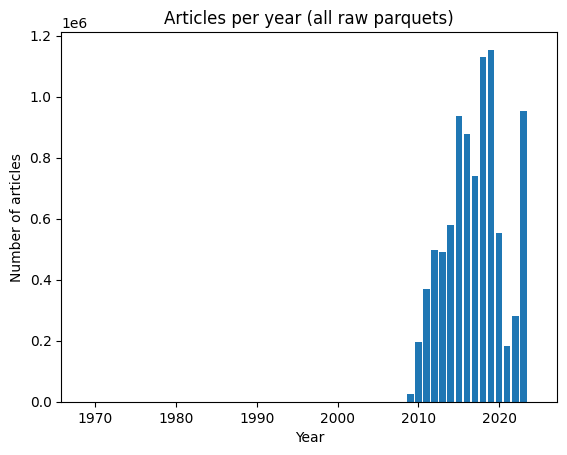

In [ ]:
# number of articles per year among all parquet 

year_counter = Counter()

for f in files:
    df = pd.read_parquet(f, columns=["dt_utc"])
    dt = pd.to_datetime(df["dt_utc"], utc=True, errors="coerce")
    year_counter.update(dt.dt.year.dropna().astype(int))

years = sorted(year_counter)
counts = [year_counter[y] for y in years]

plt.figure()
plt.bar(years, counts)
plt.xlabel("Year")
plt.ylabel("Number of articles")
plt.title("Articles per year (all raw parquets)")
plt.show()

In [ ]:
hour_counter = Counter()

for f in files:
    df = pd.read_parquet(f, columns=["dt_utc"])
    dt = pd.to_datetime(df["dt_utc"], utc=True, errors="coerce")
    hour_counter.update(dt.dt.hour.dropna().astype(int))

hours = list(range(24))
counts = [hour_counter.get(h, 0) for h in hours]

plt.figure()
plt.bar(hours, counts)
plt.xlabel("Hour (UTC)")
plt.ylabel("Number of articles")
plt.title("Hourly distribution (all raw parquets)")
plt.xticks(range(0, 24))
plt.show()

In [ ]:
files = sorted(Path("../data/fnspid_raw").glob("raw_*.parquet"))

rows = []
missing_url_tokens = {"", "none", "nan", "null", "n/a"}

for f in files:
    df = pd.read_parquet(
        f,
        columns=["article", "title", "url", "dt_utc"]
    )

    n_total = len(df)

    # article
    n_article_notna = df["article"].notna().sum()
    n_article_na = n_total - n_article_notna

    # title
    n_title_notna = df["title"].notna().sum()
    n_title_na = n_total - n_title_notna

    # url
    url = df["url"].astype("string").str.strip().str.lower()
    is_url_missing = url.isna() | url.isin(missing_url_tokens)
    n_url_missing = is_url_missing.sum()
    n_url_present = n_total - n_url_missing

    # heure dt_utc
    dt = pd.to_datetime(df["dt_utc"], utc=True, errors="coerce")
    hours = dt.dt.hour
    n_hour_not_00 = (hours != 0).sum()
    n_hour_00 = (hours == 0).sum()

    rows.append({
        "parquet": f.name,
        "total": n_total,

        "article_not_none": n_article_notna,
        "article_none": n_article_na,
        "share_article": n_article_notna / n_total if n_total else 0.0,

        "title_not_none": n_title_notna,
        "title_none": n_title_na,
        "share_title": n_title_notna / n_total if n_total else 0.0,

        "url_present": int(n_url_present),
        "url_missing": int(n_url_missing),
        "share_url_missing": n_url_missing / n_total if n_total else 0.0,

        "hour_not_00": int(n_hour_not_00),
        "hour_00": int(n_hour_00),
        "share_hour_not_00": n_hour_not_00 / n_total if n_total else 0.0,
    })

df_info = pd.DataFrame(rows).sort_values("parquet").reset_index(drop=True)

# affichage propre
df_info.style.format({
    "share_article": "{:.4f}",
    "share_title": "{:.4f}",
    "share_url_missing": "{:.4f}",
    "share_hour_not_00": "{:.4f}",
})

,parquet,total,article_not_none,article_none,share_article,title_not_none,title_none,share_title,url_present,url_missing,share_url_missing,hour_not_00,hour_00,share_hour_not_00
0,raw_00.parquet,500000,0,500000,0.0000,500000,0,1.0000,500000,0,0.0000,18861,481139,0.0377
1,raw_01.parquet,500000,0,500000,0.0000,500000,0,1.0000,500000,0,0.0000,19379,480621,0.0388
2,raw_02.parquet,500000,0,500000,0.0000,500000,0,1.0000,500000,0,0.0000,16249,483751,0.0325
3,raw_03.parquet,500000,0,500000,0.0000,500000,0,1.0000,500000,0,0.0000,0,500000,0.0000
4,raw_04.parquet,500000,0,500000,0.0000,500000,0,1.0000,500000,0,0.0000,0,500000,0.0000
5,raw_05.parquet,500000,0,500000,0.0000,500000,0,1.0000,500000,0,0.0000,0,500000,0.0000
6,raw_06.parquet,500000,267227,232773,0.5345,500000,0,1.0000,500000,0,0.0000,3565,496435,0.0071
7,raw_07.parquet,500000,500000,0,1.0000,500000,0,1.0000,500000,0,0.0000,6345,493655,0.0127
8,raw_08.parquet,500000,500000,0,1.0000,500000,0,1.0000,500000,0,0.0000,5055,494945,0.0101
9,raw_09.parquet,500000,499998,2,1.0000,500000,0,1.0000,500000,0,0.0000,7086,492914,0.0142


## Preprocessed data

This section is used to observe the characteristics of preprocessed data. (be sure to have run and 'scripts/08_raw_text_data.py' and 'scripts/09_clean_text_data.py'  before running the cells in this section).

In [21]:
OUT_DIR = ROOT / 'Modality-aware-transformer' / "data" / "fnspid_preprocessed"
files = sorted(OUT_DIR.glob("preprocessed_*.parquet"))

print("OUT_DIR:", OUT_DIR)
print("Found:", len(files), "files")
files

OUT_DIR: /Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_preprocessed
Found: 6 files


[PosixPath('/Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_preprocessed/preprocessed_2009_2012.parquet'),
 PosixPath('/Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_preprocessed/preprocessed_2013_2014.parquet'),
 PosixPath('/Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_preprocessed/preprocessed_2015_2016.parquet'),
 PosixPath('/Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_preprocessed/preprocessed_2017_2018.parquet'),
 PosixPath('/Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_preprocessed/preprocessed_2019_2020.parquet'),
 PosixPath('/Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_preprocessed/preprocessed_2021_2024.parquet')]

In [17]:
# test dates order

rows = []

for f in files:
    df = pd.read_parquet(f)
    assert df["effective_date"].is_monotonic_increasing
    print(f"Dates are sorted :",f)
    n = pd.read_parquet(f, columns=["effective_date"]).shape[0]
    rows.append({"file": f.name, "rows": n, "size_mb": f.stat().st_size / (1024**2)})

df_rows = pd.DataFrame(rows).sort_values("file")
df_rows

Dates are sorted : /Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_preprocessed/preprocessed_2009_2012.parquet
Dates are sorted : /Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_preprocessed/preprocessed_2013_2014.parquet
Dates are sorted : /Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_preprocessed/preprocessed_2015_2016.parquet
Dates are sorted : /Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_preprocessed/preprocessed_2017_2018.parquet
Dates are sorted : /Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_preprocessed/preprocessed_2019_2020.parquet
Dates are sorted : /Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_preprocessed/preprocessed_2021_2024.parquet


,file,rows,size_mb
0,preprocessed_2009_2012.parquet,573625,34.889161
1,preprocessed_2013_2014.parquet,612283,38.829513
2,preprocessed_2015_2016.parquet,1019628,70.137135
3,preprocessed_2017_2018.parquet,1105714,75.014999
4,preprocessed_2019_2020.parquet,984378,69.855458
5,preprocessed_2021_2024.parquet,1413857,61.555123


In [24]:
df = pd.read_parquet(f)
df

,effective_date,publication_date,stock_symbol,text,text_source,text_len,publisher,url
0,2021-01-04,2021-01-04,AAL,Why Airline Shares Are Falling Today,title,6,None,https://www.nasdaq.com/articles/why-airline-sh...
1,2021-01-04,2021-01-04,AAL,Will Vaccine Shipments Save the Airlines in 2021?,title,8,None,https://www.nasdaq.com/articles/will-vaccine-s...
2,2021-01-04,2021-01-04,AAL,"Breakingviews - ""Big Four"" U.S. airlines are g...",title,13,None,https://www.nasdaq.com/articles/breakingviews-...
3,2021-01-04,2021-01-04,AAL,Major U.S. airlines back 'global' COVID-19 tes...,title,9,None,https://www.nasdaq.com/articles/major-u.s.-air...
4,2021-01-04,2021-01-04,AAL,Major U.S. airlines back expanding COVID-19 te...,title,11,None,https://www.nasdaq.com/articles/major-u.s.-air...
...,...,...,...,...,...,...,...,...
1413852,2024-01-09,2024-01-09,AMD,Japan's Nikkei hits 33-year high as tech stock...,title,9,None,https://www.nasdaq.com/articles/japans-nikkei-...
1413853,2024-01-09,2024-01-09,AMD,Will Advanced Micro Devices Be a Trillion-Doll...,title,10,None,https://www.nasdaq.com/articles/will-advanced-...
1413854,2024-01-09,2024-01-09,AMD,Zacks Industry Outlook Highlights Advanced Mic...,title,13,None,https://www.nasdaq.com/articles/zacks-industry...
1413855,2024-01-09,2024-01-09,AMD,AMD Strengthens Portfolio With New Radeon & Ry...,title,9,None,https://www.nasdaq.com/articles/amd-strengthen...


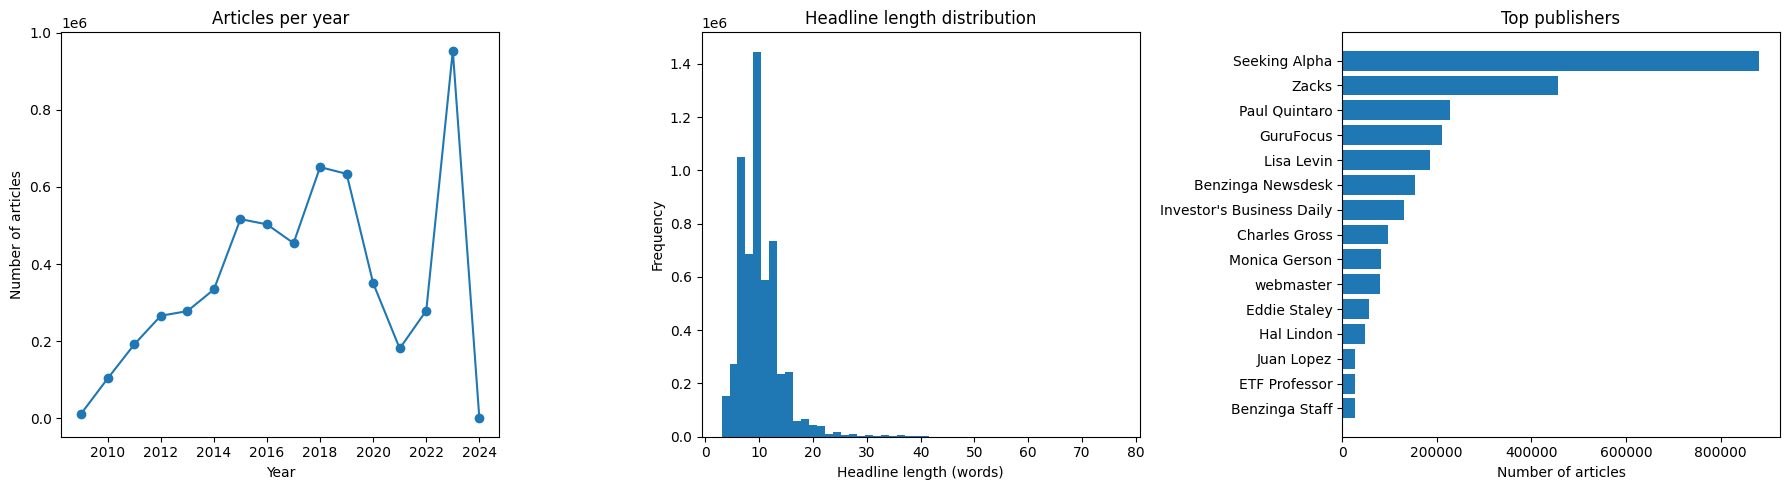

In [ ]:
years = pd.concat(
    pd.read_parquet(f, columns=["effective_date"])["effective_date"]
    for f in files
)
years = pd.to_datetime(years, errors="coerce").dt.year.dropna().astype(int)
year_counts = years.value_counts().sort_index()

lengths = pd.concat(
    pd.read_parquet(f, columns=["text_len"])["text_len"]
    for f in files
).dropna()

publishers = pd.concat(
    pd.read_parquet(f, columns=["publisher"])["publisher"]
    for f in files
).dropna()
top_publishers = publishers.value_counts().head(15)


# Plots

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Articles per year
axes[0].plot(year_counts.index, year_counts.values, marker="o")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of articles")
axes[0].set_title("Articles per year")

# 2. Headline length distribution
axes[1].hist(lengths, bins=50)
axes[1].set_xlabel("Headline length (words)")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Headline length distribution")

# 3. Top publishers
axes[2].barh(top_publishers.index[::-1], top_publishers.values[::-1])
axes[2].set_xlabel("Number of articles")
axes[2].set_title("Top publishers")

plt.tight_layout()
plt.show()

In [ ]:
# collect all the dates 
dates = []
for f in tqdm(files, desc="Read effective_date", unit="file"):
    s = pd.read_parquet(f, columns=["effective_date"])["effective_date"]
    s = pd.to_datetime(s, errors="coerce").dropna().dt.normalize()
    dates.append(s)

dates = pd.concat(dates, ignore_index=True).drop_duplicates().sort_values()

# stats by year
rows = []
for year, g in dates.groupby(dates.dt.year):
    start, end = g.iloc[0], g.iloc[-1]
    full_B = pd.date_range(start, end, freq="B")  # lun-ven
    n_present = int(g.nunique())

    rows.append({
        "year": int(year),
        "start": start.date(),
        "end": end.date(),
        "n_days_present": n_present,
        "n_business_days": int(full_B.size),
        "n_missing_business_days": int(full_B.size - g.isin(full_B).sum()),
        "coverage_B": float(n_present / full_B.size) if full_B.size else 0.0,
    })

by_year = pd.DataFrame(rows).sort_values("year").reset_index(drop=True)
display(by_year)

Read effective_date: 100%|██████████| 6/6 [00:00<00:00, 16.27file/s]


,year,start,end,n_days_present,n_business_days,n_missing_business_days,coverage_B
0,2009,2009-02-17,2009-12-31,148,228,80,0.649123
1,2010,2010-01-04,2010-12-31,252,260,8,0.969231
2,2011,2011-01-03,2011-12-30,252,260,8,0.969231
3,2012,2012-01-03,2012-12-31,250,260,10,0.961538
4,2013,2013-01-02,2013-12-31,252,260,8,0.969231
5,2014,2014-01-02,2014-12-31,252,260,8,0.969231
6,2015,2015-01-02,2015-12-31,252,260,8,0.969231
7,2016,2016-01-04,2016-12-30,252,260,8,0.969231
8,2017,2017-01-03,2017-12-29,251,259,8,0.969112
9,2018,2018-01-02,2018-12-31,251,260,9,0.965385


Reading preprocessed files: 100%|██████████| 6/6 [00:00<00:00, 38.79file/s]


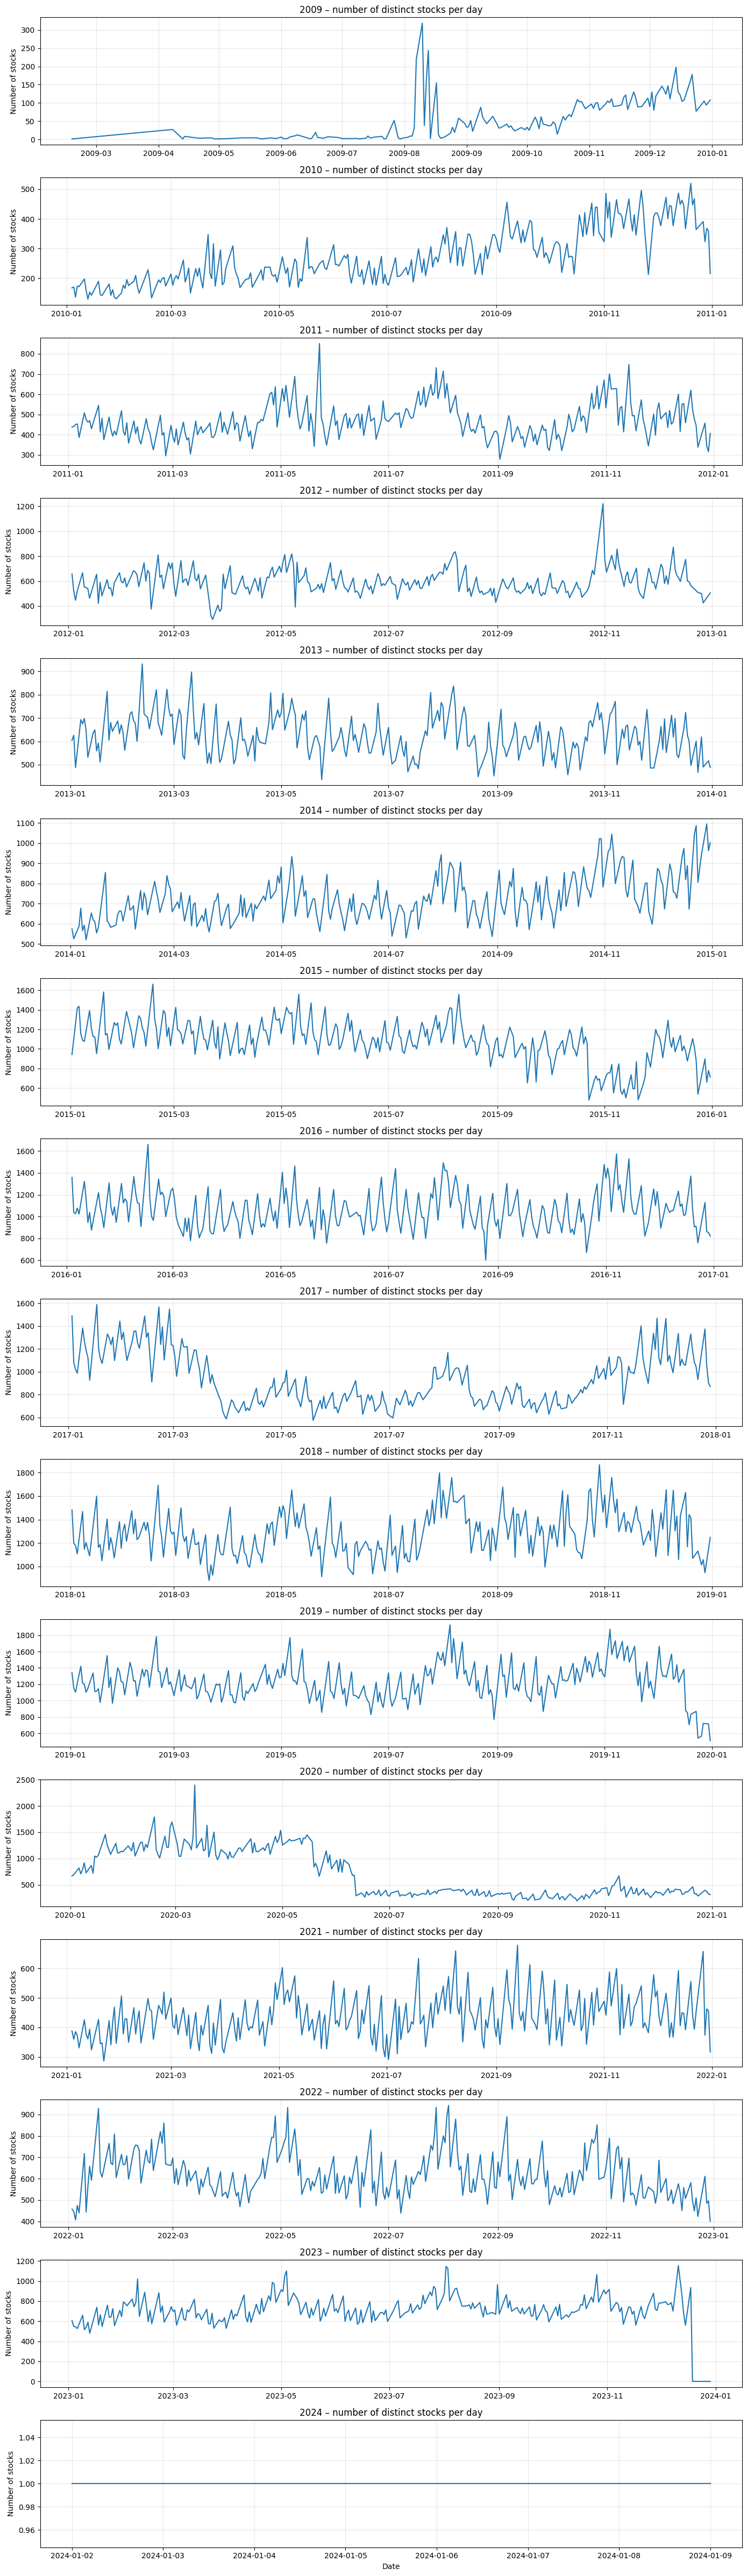

In [31]:
dfs = []
for f in tqdm(files, desc="Reading preprocessed files", unit="file"):
    df = pd.read_parquet(f, columns=["effective_date", "stock_symbol"])
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)


# Clean + aggregate

df["effective_date"] = pd.to_datetime(df["effective_date"], errors="coerce")
df = df.dropna(subset=["effective_date", "stock_symbol"])

df["date"] = df["effective_date"].dt.normalize()
df["year"] = df["date"].dt.year

# nombre de stocks distincts par jour
daily_counts = (
    df.groupby(["year", "date"])["stock_symbol"]
    .nunique()
    .reset_index(name="n_stocks")
)

# Plot: one subplot per year

years = sorted(daily_counts["year"].unique())
n_years = len(years)

fig, axes = plt.subplots(
    n_years, 1,
    figsize=(14, 3 * n_years),
    sharex=False
)

if n_years == 1:
    axes = [axes]

for ax, year in zip(axes, years):
    g = daily_counts[daily_counts["year"] == year]

    ax.plot(g["date"], g["n_stocks"])
    ax.set_title(f"{year} – number of distinct stocks per day")
    ax.set_ylabel("Number of stocks")
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

In [33]:
# Recap per year

by_year = (
    daily_counts
    .groupby("year")["n_stocks"]
    .agg(
        mean_stocks="mean",
        min_stocks="min",
        max_stocks="max",
    )
    .reset_index()
    .sort_values("year")
)

display(by_year)

,year,mean_stocks,min_stocks,max_stocks
0,2009,57.554054,1,319
1,2010,272.035714,129,520
2,2011,468.579365,278,851
3,2012,593.524000,292,1221
4,2013,626.757937,436,932
5,2014,729.567460,520,1094
6,2015,1076.432540,478,1662
7,2016,1054.571429,600,1661
8,2017,935.211155,576,1587
9,2018,1282.282869,881,1867


## Features

### Stock/Data Level

In [43]:
OUT_DIR = ROOT / 'Modality-aware-transformer' / "data" / "fnspid_features_text_stock_date"
files = sorted(OUT_DIR.glob("text_features_stock_date_*.parquet"))

print("OUT_DIR:", OUT_DIR)
print("Found:", len(files), "files")
files

OUT_DIR: /Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_features_text_stock_date
Found: 6 files


[PosixPath('/Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_features_text_stock_date/text_features_stock_date_2009_2012.parquet'),
 PosixPath('/Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_features_text_stock_date/text_features_stock_date_2013_2014.parquet'),
 PosixPath('/Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_features_text_stock_date/text_features_stock_date_2015_2016.parquet'),
 PosixPath('/Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_features_text_stock_date/text_features_stock_date_2017_2018.parquet'),
 PosixPath('/Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_features_text_stock_date/text_features_stock_date_2019_2020.parquet'),
 PosixPath('/Users/brianramesh/Documents/ MAT_implementation/Modality-aware-transformer/data/fnspid_features_text_stock_date/text_features_stock_

In [46]:
df = pd.read_parquet('../data/fnspid_features_text_stock_date/text_features_stock_date_2021_2024.parquet')
df.sort_values('effective_date').head()

,stock_symbol,effective_date,n_news,log_n_news,sent_score_mean,sent_score_std,sent_pos_mean,sent_neg_mean,sent_neu_mean,sent_score_sum,sent_pos_sum,sent_neg_sum,sent_neu_sum,emb_mean
162208,EWZ,2021-01-04,1,0.693147,0.915453,0.000000,0.942067,0.026614,0.031320,0.915453,0.942067,0.026614,0.031320,"[-0.011925, 0.004875, 0.03555, -0.03522, 0.066..."
321117,RDHL,2021-01-04,1,0.693147,0.013337,0.000000,0.022333,0.008996,0.968672,0.013337,0.022333,0.008996,0.968672,"[-0.006363, -0.007996, 0.0007544, -0.03754, 0...."
259186,NG,2021-01-04,3,1.386294,-0.860768,0.034669,0.055877,0.916645,0.027478,-2.582303,0.167632,2.749935,0.082434,"[0.04318, -0.01283, 0.02977, -0.0181, 0.03613,..."
199801,GRFS,2021-01-04,1,0.693147,-0.861909,0.000000,0.041806,0.903716,0.054478,-0.861909,0.041806,0.903716,0.054478,"[0.04376, -0.0188, 0.07416, -0.01218, 0.0088, ..."
133451,DOC,2021-01-04,1,0.693147,0.030625,0.000000,0.047561,0.016936,0.935504,0.030625,0.047561,0.016936,0.935504,"[8.07e-05, -0.00927, 0.02966, 0.003736, 0.0445..."


### Day Level (Topic)

## Final Table

In [48]:
df = pd.read_parquet('../data/fnspid_features_text_stock_date/linked_text_features_stock_date.parquet')
df

,stock_symbol,effective_date,n_news,log_n_news,sent_score_mean,sent_score_std,sent_pos_mean,sent_neg_mean,sent_neu_mean,sent_score_sum,sent_pos_sum,sent_neg_sum,sent_neu_sum,emb_mean,date,permno,comnam
0,A,2009-04-29,1,0.693147,0.640473,0.000000,0.797031,0.156558,0.046411,0.640473,0.797031,0.156558,0.046411,"[0.02, 0.009865, -0.02325, -0.02739, 0.0288, -...",2009-04-29,87432,AGILENT TECHNOLOGIES INC
1,A,2009-06-01,1,0.693147,0.182774,0.000000,0.569713,0.386940,0.043347,0.182774,0.569713,0.386940,0.043347,"[0.03192, -0.02007, 0.05035, 0.01374, 0.02689,...",2009-06-01,87432,AGILENT TECHNOLOGIES INC
2,A,2009-07-14,1,0.693147,-0.039747,0.000000,0.471723,0.511471,0.016806,-0.039747,0.471723,0.511471,0.016806,"[0.02332, 0.02065, 0.01075, -0.02846, 0.04706,...",2009-07-14,87432,AGILENT TECHNOLOGIES INC
3,A,2009-07-30,1,0.693147,0.853239,0.000000,0.915127,0.061889,0.022984,0.853239,0.915127,0.061889,0.022984,"[0.0103, 0.01698, -0.000989, -0.01309, 0.02892...",2009-07-30,87432,AGILENT TECHNOLOGIES INC
4,A,2009-08-04,1,0.693147,0.831451,0.000000,0.896045,0.064593,0.039362,0.831451,0.896045,0.064593,0.039362,"[0.0293, 0.0101, 0.001484, 0.01054, 0.0706, -0...",2009-08-04,87432,AGILENT TECHNOLOGIES INC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795258,ZTS,2023-12-04,1,0.693147,0.864468,0.000000,0.925563,0.061095,0.013342,0.864468,0.925563,0.061095,0.013342,"[-0.003775, 0.04977, -0.000934, 0.0005145, 0.0...",2023-12-04,13788,ZOETIS INC
795259,ZTS,2023-12-07,1,0.693147,0.868984,0.000000,0.912896,0.043912,0.043192,0.868984,0.912896,0.043912,0.043192,"[0.02042, -0.03497, 0.02292, 0.00946, 0.03217,...",2023-12-07,13788,ZOETIS INC
795260,ZTS,2023-12-08,1,0.693147,0.921098,0.000000,0.945110,0.024011,0.030879,0.921098,0.945110,0.024011,0.030879,"[0.003391, 0.02028, 0.06976, -0.012726, 0.0223...",2023-12-08,13788,ZOETIS INC
795261,ZTS,2023-12-11,4,1.609438,-0.071311,0.817599,0.435251,0.506562,0.058187,-0.285242,1.741004,2.026247,0.232749,"[0.01598, -0.000758, 0.05273, 0.00938, 0.0228,...",2023-12-11,13788,ZOETIS INC
